# Notebook for testing simple neural network setup

In [1]:
import autograd.numpy as np  # We need to use this numpy wrapper to make automatic differentiation work later
from sklearn import datasets
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from numpy.typing import NDArray

# Setting the random seed
np.random.seed(42)


In [2]:

# Defining some activation functions
def ReLU(z):
    return np.where(z > 0, z, 0)


def sigmoid(z):
    return 1 / (1 + np.exp(-z))


def softmax(z):
    """Compute softmax values for each set of scores in the rows of the matrix z.
    Used with batched input data."""
    e_z = np.exp(z - np.max(z, axis=0))
    return e_z / np.sum(e_z, axis=1)[:, np.newaxis]


def softmax_vec(z):
    """Compute softmax values for each set of scores in the vector z.
    Use this function when you use the activation function on one vector at a time"""
    e_z = np.exp(z - np.max(z))
    return e_z / np.sum(e_z)

In [3]:
def create_layers_batch(network_input_size : int, layer_output_sizes : list):
    layers = []

    # Number of inputs in the current layer
    i_size = network_input_size

    # For each output layer size
    for layer_output_size in layer_output_sizes:

        # w has the shape of the current output layer size x the current input size
        W = np.random.randn(i_size, layer_output_size)

        # b has the shape of the current output layer size, 1
        b = np.random.randn(1, layer_output_size)
        
        # Append to the layer list
        layers.append((W, b))

        # Update i_size to the output size of the current layer
        i_size = layer_output_size
    return layers

In [4]:
def feed_forward_batch(inputs : NDArray, layers : list, activation_funcs : list):
    # Set the current a to the input vector
    a = inputs

    # For each layer and activation function
    for (W, b), activation_func in zip(layers, activation_funcs):

        # Calculate z for the current W and b, and the previous a
        z = a @ W + b

        # Calculate a using the given activation function
        a = activation_func(z)

    return a

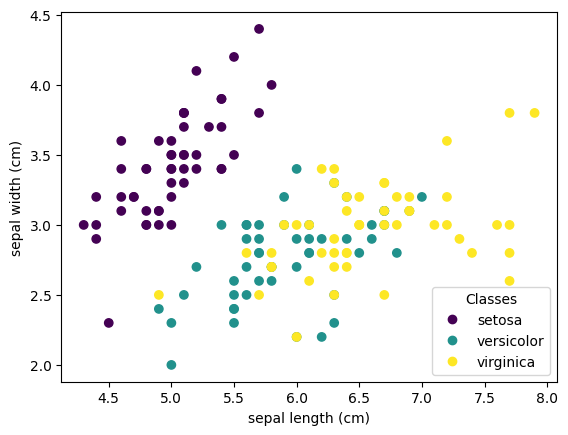

In [5]:
iris = datasets.load_iris()

_, ax = plt.subplots()
scatter = ax.scatter(iris.data[:, 0], iris.data[:, 1], c=iris.target)
ax.set(xlabel=iris.feature_names[0], ylabel=iris.feature_names[1])
_ = ax.legend(
    scatter.legend_elements()[0], iris.target_names, loc="lower right", title="Classes"
)

In [6]:
inputs = iris.data

# Since each prediction is a vector with a score for each of the three types of flowers,
# we need to make each target a vector with a 1 for the correct flower and a 0 for the others.
targets = np.zeros((len(iris.data), 3))
for i, t in enumerate(iris.target):
    targets[i, t] = 1


def accuracy(predictions, targets):
    one_hot_predictions = np.zeros(predictions.shape)

    for i, prediction in enumerate(predictions):
        one_hot_predictions[i, np.argmax(prediction)] = 1
    return accuracy_score(one_hot_predictions, targets)

In [7]:
def cross_entropy(predict, target):
    return np.sum(-target * np.log(predict))


def cost(input, layers, activation_funcs, target):
    predict = feed_forward_batch(input, layers, activation_funcs)
    return cross_entropy(predict, target)

In [8]:
inputs = iris.data
activation_funcs = [sigmoid, softmax]
network_input_size = 4
layer_output_sizes = [8, 3]
layers = create_layers_batch(network_input_size, layer_output_sizes)
layers2 = create_layers_batch(network_input_size, layer_output_sizes)

In [9]:
from autograd import grad

gradient_func = grad(cost, 1)  # Taking the gradient wrt. the second input to the cost function, i.e. the layers
layers_grad = gradient_func(inputs, layers, activation_funcs, targets)  # Don't change this

In [10]:
def train_network(inputs, layers, activation_funcs, targets, learning_rate=0.001, epochs=100):
    acc = []
    for i in range(epochs):
        layers_grad = gradient_func(inputs, layers, activation_funcs, targets)
        for (W, b), (W_g, b_g) in zip(layers, layers_grad):
            W -= W_g * learning_rate
            b -= b_g * learning_rate


        if i % 10 == 0:
            predictions = feed_forward_batch(inputs, layers, activation_funcs)
            current_acc = accuracy(predictions, targets)

            #print(f"Accuracy after epoch {i} is {current_acc:.3f}")

            acc.append(current_acc)
            
    return layers, acc

In [11]:
def train_network_momentum(inputs, layers, activation_funcs, targets, eta=0.001, alpha=0.9, epochs=100, tolerance=1e-6):

    acc = []

    # Initialize velocities to 0
    velocities = []
    for W, b in layers:
        W_v = np.zeros_like(W)
        b_v = np.zeros_like(b)
        velocities.append((W_v, b_v))

    # In each epoch
    for i in range(epochs):
        # Find the gradients of each layer
        layers_grad = gradient_func(inputs, layers, activation_funcs, targets)

        # For each weight and bias, and their corresponding gradient
        for indx, ((W, b), (W_g, b_g), (W_v, b_v)) in enumerate(zip(layers, layers_grad, velocities)):

            # Compute the velocity of the weight and bias
            W_v = alpha * W_v - eta * W_g
            b_v = alpha * b_v - eta * b_g

            # Compute the new weight and bias values
            W_n = W + W_v
            b_n = b + b_v

            """# Check convergence
            if (np.linalg.norm(W_n - W) < tolerance or np.linalg.norm(b_n - b) < tolerance):
                print("W_n - W = ", np.linalg.norm(W_n - W) < tolerance)
                print("b_n - b = ", np.linalg.norm(b_n - b) < tolerance)
                print(f"Convergence in epoch {i}")
                break"""
            
            # Update weight and bias of the current layer
            layers[indx] = (W_n, b_n)
            velocities[indx] = (W_v, b_v)


        if i % 10 == 0:
            predictions = feed_forward_batch(inputs, layers, activation_funcs)
            current_acc = accuracy(predictions, targets)

            #print(f"Accuracy after epoch {i} is {current_acc:.3f}")

            acc.append(current_acc)
            
    return layers, acc

In [12]:
def train_network_momentum2(inputs, layers, activation_funcs, targets, eta=0.001, alpha=0.9, epochs=100, tolerance=1e-6):

    acc = []

    # Initialize velocities to 0
    velocities = []
    for W, b in layers:
        W_v = np.zeros_like(W)
        b_v = np.zeros_like(b)
        velocities.append((W_v, b_v))

    # In each epoch
    for i in range(epochs):
        # Find the gradients of each layer
        layers_grad = gradient_func(inputs, layers, activation_funcs, targets)

        # For each weight and bias, and their corresponding gradient
        for indx in range(len(layers)):
            
            W, b = layers[indx]
            W_g, b_g = layers_grad[indx]
            W_v, b_v = velocities[indx]

            # Compute the velocity of the weight and bias
            W_v = alpha * W_v - eta * W_g
            b_v = alpha * b_v - eta * b_g

            # Compute the new weight and bias values
            W_n = W + W_v
            b_n = b + b_v
            
            # Update weight and bias of the current layer
            layers[indx] = (W_n, b_n)
            velocities[indx] = (W_v, b_v)

        if i % 25 == 0:
            predictions = feed_forward_batch(inputs, layers, activation_funcs)
            current_acc = accuracy(predictions, targets)

            print(f"Accuracy after epoch {i} is {current_acc:.3f}")

            acc.append(current_acc)
            
    return layers, acc

In [13]:
layers, acc = train_network(inputs, layers, activation_funcs, targets, epochs=250)
layers2, acc2 = train_network_momentum(inputs, layers2, activation_funcs, targets, epochs=250)


Final accuracy after 250 epochs (vanilla) =  0.94
Final accuracy after 250 epochs (GDM) =  0.98


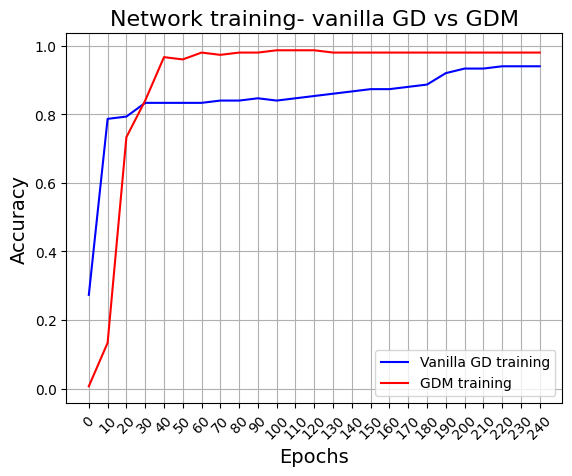

In [17]:
epoch_interval = 10
epochs = [i * epoch_interval for i in range(len(acc))]
epochs2 = [i * epoch_interval for i in range(len(acc2))]

plt.plot(epochs, acc, '-', color="blue", label="Vanilla GD training")
plt.plot(epochs2, acc2, '-', color="red", label="GDM training")
plt.xticks(epochs, rotation=45)
plt.grid()
plt.title("Network training- vanilla GD vs GDM", fontsize=16)
plt.xlabel("Epochs", fontsize=14)
plt.ylabel("Accuracy", fontsize=14)
plt.legend()

print(f"Final accuracy after {len(acc) * epoch_interval} epochs (vanilla) = ", acc[-1])
print(f"Final accuracy after {len(acc) * epoch_interval} epochs (GDM) = ", acc2[-1])